# Linear track demo

Here we load sorted unit data obtained from MatClust to identify putative place cells. The session has about 15 minutes of linear track running, followed by 15 minutes of rest. 

Data was recorded by _Joshua Chu_, with a Spikegadgets wireless headstage, on July 8th, 2017, from the CA! area of a male Long-Evans rat named `install`.

Notebook was created by _Etienne Ackermann_.

### Preliminaries

We use the following Python packages; they can be installed either with `conda install <pkg>` or with `pip install <pkg>`. Most of these packages are very common, and it is more than likely that you have them installed already. 

It doesn't hurt to type `pip install <pkg>` if the package is already installed, so don't be nervous to try it out!

```bash
pip install nelpy
```

**For downloading example data from the web:**
```python
1. requests   # used to download data from web
2. tqdm       # used to show progress of download
```

**the rest of this notebook:**
```python
3. numpy      # numerical powerhorse for Python
4. matplotlib # used to make plots and figures
5. scipy      # signal processing, stats, etc.; used here to smooth signals
6. sklearn    # machine learning in Python; used here to do train-test split 
              # (under the hood) when evaluating Bayesian decoding performance
```

**and of course:**
```python
7. nelpy      # Ephys object models, and analysis routines
```

Now that we have all the packages we nee, let's get started! First, we need to get the sample data...

## 1. Obtain example data

We will look for data in the `example-data\linear-track\` directory inside your current working directory. If the data doesn't exist, we will download it from https://github.com/nelpy/example-data, and save it to your local machine. 

If you already have the data, it won't be downloaded again.

In particular, we will download two files, namely
 1. `trajectory.videoPositionTracking` which is a binary file with (x,y) position coordinate pairs and timestamps, and
 2. `spikes.mat` which is a Matlab file containing information about sorted units (cells) obtained by using MatClust (https://bitbucket.org/mkarlsso/matclust).

In [1]:
import os
import requests

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

datadir = os.path.join(os.getcwd(), 'example-data\linear-track')
os.makedirs(datadir, exist_ok=True)

filenames = []
filenames.append(os.path.join(datadir, 'trajectory.videoPositionTracking'))
filenames.append(os.path.join(datadir, 'spikes.mat'))
urls = []
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/trajectory.videoPositionTracking')
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/spikes.mat')

for filename, url in zip(filenames, urls):
    if os.path.exists(filename):
        print('you already have the example data, skipping download...')
    else:
        print('downloading data from {}'.format(url))
        # Streaming, so we can iterate over the response.
        r = requests.get(url, stream=True)

        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0)); 
        chunk_size = 1024 # number of bytes to process at a time (NOTE: progress bar unit only accurate if this is 1 kB)

        with open(filename, 'wb+') as f:
            for data in tqdm(r.iter_content(chunk_size), total=int(total_size/chunk_size), unit='kB'):
                f.write(data)
            
        print('data saved to local directory {}'.format(filename))

filename_pos = filenames[0]
filename_spikes = filenames[1]

downloading data from https://github.com/nelpy/example-data/raw/master/linear-track/trajectory.videoPositionTracking


1395kB [00:11, 126.58kB/s]                                                     


data saved to local directory C:\temp\example-analyses\example-data\linear-track\trajectory.videoPositionTracking
downloading data from https://github.com/nelpy/example-data/raw/master/linear-track/spikes.mat


173kB [00:05, 30.40kB/s]                                                       


data saved to local directory C:\temp\example-analyses\example-data\linear-track\spikes.mat


## 2. Import packages

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

## 3. Extract position data

The position data is stored in a binary file, and we already made a reference to it as `filename_pos`, which should point to `./example-data/linear-track/trajectory.videoPositionTracking`, inside your current working directory.

More information about the format of the file can be obtained at https://github.com/nelpy/example-data/tree/master/linear-track .

Here we define a simple function to read the plaintext header from the file, since the header also informs us of the format of the rest of the data.

In [3]:
def print_header(filename, timeout=50):
    """Reads header lines from a SpikeGadgets .rec file, and prints it to screen."""
    linecount = 0
    with open(filename, 'rb') as fileobj:
        instr = fileobj.readline()
        linecount += 1
        while (instr != b'<End settings>\n') :
            print(instr)
            instr = fileobj.readline()
            if linecount > timeout:
                break
    print(instr)

In [4]:
print_header(filename_pos)

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'
b'<End settings>\n'


Armed with this new information, we read over the header, and then extract (1) the 32 bit unsigned `timestamp`, as well as (2) the 16 bit unsigned position data into lists `x1` and `y1` (`x2` and `y2` were not used in this recording, and can be ignored).

In [5]:
n_packets = 500000
timestamps = []
x1 = []
y1 = []
x2 = []
y2 = []
ii = 0
with open(filename_pos, 'rb') as fileobj:
    instr = fileobj.readline()
    
    n_max_header_lines = 50
    hh = 0
    # consume all header lines
    while (instr != b'<End settings>\n') :
        hh +=1
        instr = fileobj.readline()
        if hh > n_max_header_lines:
            print('End of header not found! Aborting...')
            break
    for packet in iter(lambda: fileobj.read(12), ''):
        if packet:
            ts_ = struct.unpack('<L', packet[0:4])[0]
            x1_ = struct.unpack('<H', packet[4:6])[0]
            y1_ = struct.unpack('<H', packet[6:8])[0]
            x2_ = struct.unpack('<H', packet[8:10])[0]
            y2_ = struct.unpack('<H', packet[10:12])[0]
            timestamps.append(ts_)
            x1.append(x1_)
            y1.append(y1_)
            x2.append(x2_)
            y2.append(y2_)
        else:
            break
        if ii >= n_packets:
            print('Stopped before reaching end of file')
            break

**Remark**: up to this point, we have not used `nelpy` yet. We have our position as two lists `x1` and `y1`, along with a list of `timestamps`. But working with these lists of coordinates and timestamps directly can be tedious and error-prone. Consequently, we will wrap the data into `nelpy` objects to make our life easier.

### 3.a) Get session boundaries

First, we will estimate epochs during which the animal was supposed to be running on the track, and those for which the animal was in its sleep box. Note that this task can be a little tricky to estimate directly from the data, since the animal is not always running while on the track, and may in fact just be stationary for significant periods.

We can (and probably should) of course get the experimantal epochs (that of running on the track, and that of resting in the sleep box) from our lab notes, but it's always good to make sure that your data agrees with your notes, and moreover, it demonstrates how we can use `nelpy` to estimate these epochs in case our notes were lost, or inaccurate.

In [6]:
# we estimate large periods of inactivity as periods where the animal's estimated position did not move for at least 10 seconds
minLength = 600 # 10 seconds @ 60 fps
bounds, _, _ = nel.utils.get_events_boundaries(np.gradient(x1),
                                               PrimaryThreshold=0, 
                                               SecondaryThreshold=0, 
                                               mode='below', 
                                               minLength=minLength, 
                                               ds=1
                                              )

# bounds are now in sample numbers, so we convert them to time using timestamps
FS = 30000
bounds_ts = np.zeros(bounds.shape)
for row in range(len(bounds)):
    for col in range(2):
        bounds_ts[row,col] = timestamps[bounds[row,col]]
        


Here we've used `nelpy` to get event boundaries, in sample numbers, where the animal spent at least 10 seconds with zero change in its `x1` coordinate. We could do this, because the tracker does not track the animal when it is in the sleep box (it is outside of the camera's view).

Next, we create our first `nelpy` object, namely an `EpochArray` containing all the epochs defined by the bounds returned above.

In general it is not necessary to sort epochs like we do below, but we have to do that here because the way we build our `session_epochs` is a little convoluted: we build it by first estimating sleep box epochs, and then combine the sleep box epochs with the complement of the sleep box epochs. When we take a union of epochs, they are no longer guaranteed to be in sorted order, and so we sort them for good measure.

In [7]:
sleep_box = nel.EpochArray(bounds_ts/FS, domain=nel.EpochArray((timestamps[0]/FS, timestamps[-1]/FS)))
session_epochs = (sleep_box + ~sleep_box) # the entire session includes when the animal was in its sleep box, 
                                # and when it was not(~) in its sleep box
session_epochs._sort()

We can always inspect `nelpy` objects by printing them to screen like so:

In [8]:
print(session_epochs)

<EpochArray at 0x1bb1da52eb8: 3 epochs> of duration 33:02:423 minutes


which tells us that we have 3 epochs, with a total duration of approximately 30 minutes. 

HOWEVER! We expected to only have two epochs! One 15 minute run, followed by a 15 minute sleep box session. So what happened? Well, we can have a closer look at the epochs, by printing out their durations:

In [9]:
for ep in session_epochs:
    print(ep.duration)

25.8235 seconds
15:59:115 minutes
16:37:485 minutes


We see that the first epoch is only about 25 seconds long, and this corresponds to when we moved the animal onto the track, so we're happy to ignore that particular epoch, and focus on the other two.

Note also that `nelpy` returned a nice human readable duration for each epoch. Under the hood, the durations are stored (calculated, more accurately) in seconds, and we could have computed it ourselves like so:

In [10]:
print(session_epochs.time) # .time returns the bounds defining the epochs, in seconds; each row is [start, stop]

[[ 4397.0317      4422.85523333]
 [ 4422.85523333  5381.9703    ]
 [ 5381.9703      6379.4556    ]]


In [11]:
print(session_epochs.time[:,1] - session_epochs.time[:,0]) # durations are stops - starts

[  25.82353333  959.11506667  997.4853    ]


We see that the durations that we computed above agree with the ones we printed out earlier, but 15:59:115 minutes is arguably easier to parse than 959.11506667 seconds.

In fact, we don't even really need to call `print()` on many of the objects, and we can just invoke them to see a representation of the objects. Let's try that on our `sleep_box` object:

In [12]:
sleep_box

<EpochArray at 0x1bb2126ea58: 2 epochs> of duration 17:03:308 minutes

We see that (as we already know) there are two epochs during which we think the animal was in its sleep box, namely the first 25 seconds, and then the last 16 minutes of the recording session.

We can similarly look at the complement of the sleep box epochs, which should then be (naturally) when the animal was on the linear track:

In [13]:
~sleep_box

<EpochArray at 0x1bb21282d68: 1 epoch> of duration 15:59:115 minutes

### 3.b) Create 2D trajectory object

Next we will use our lists `x1` and `y1` to build a `nelpy` `AnalogSignalArray`. This is pretty easy: we pass in the position coordinates as a 2 x n_samples array, along with the corresponding timestamps, and we specify that we want this object to be defined on the epoch where the animal was NOT in its sleep box, i.e., when the animal was on the track.

Note also that we defined the trajectory object on a slightly smaller epoch, namely we shrunk the epoch by 20 seconds from both directions. We did this in order to be sure that the first and last parts of the trajectory were not those where we were moving the animal onto and off of the track.

In [14]:
pos = nel.AnalogSignalArray(np.vstack((x1, y1)), timestamps=np.array(timestamps)/FS, support=(~sleep_box).shrink(20), fs=60)

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [15]:
pos # inspect pos object to see if everything looks good

<AnalogSignalArray at 0x1bb229d81d0: 2 signals> for a total of 15:19:115 minutes

We can plot the position/trajectory object like so:

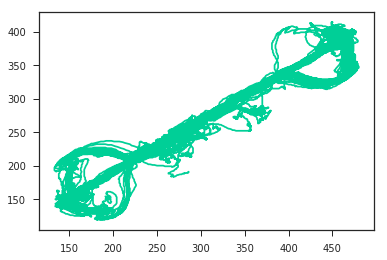

In [16]:
npl.plot2d(pos) # plot the entire trajectory

Recall that the linear track epoch ranged from approcimately 4420 to 5380 seconds (We can always get these by simply inspecting pos again, like blow):

In [17]:
pos.support.time # print the time boundaries on which pos is deifned

array([[ 4442.85523333,  5361.9703    ]])

and so we can easily plot the trajectory, say, for the first 30 seconds while the animal was on the track. One way to do this, is to define an epoch, and then to restrict the position object to that newly defined epoch. Let's do this now:

In [18]:
ep = nel.EpochArray([4442, 4472])
ep

<EpochArray at 0x1bb22a15ba8: 1 epoch> of duration 30 seconds

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


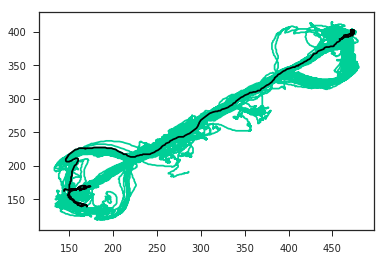

In [19]:
npl.plot2d(pos) # plot the entire trajectory
npl.plot2d(pos[ep], color='k') # plot pos restricted to ep

This way of filtering / restricting the data is very powerful, and we will use it later on to get spikes only during times when the animal was running faster than some threshold, and so on.

Before we move onto the next phase (linearization), let's take a quick aside to make the plot above a bit nicer. First, we may want to set the aspect ratio to equal, and we may also want to add titles, labels, etc. We may even want to smooth the trajectory.

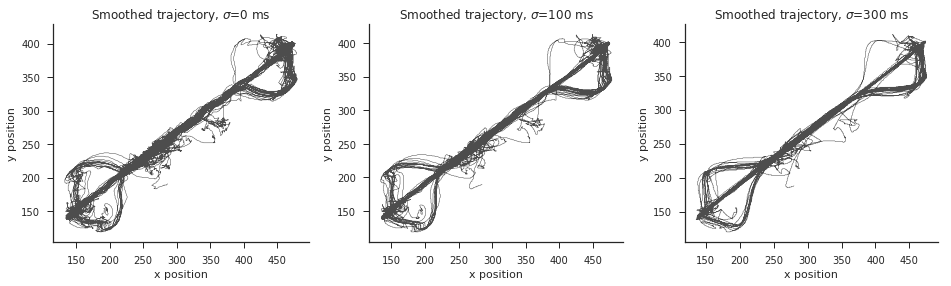

In [20]:
sigmas = [0, 0.1, 0.3] # smooth trajectory in time, with sigma = 100 ms (=0.1 seconds)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for sigma, ax in zip(sigmas, axes):
    npl.plot2d(pos.smooth(sigma=sigma), lw=0.5, color='0.3', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    ax.set_title('Smoothed trajectory, $\sigma$={} ms'.format(round(sigma*1000)))

### 3.c) Linearize position

We can do the rest of our analysis in 2D, but sometimes it's nicer to linearize the position data first. Here, we simply use PCA (a dimensionality reduction technique) to find the direction of maximal variance in our position data, and we use this as our new 1D linear track axis.

**NOTE**: To use PCA from scikit-learn, we need to provide our data as an n_samples x n_features matrix. The internal representation of the `nelpy` `AnalogSignalArray` can actually be changed, but we can always explicitly ask to get the underlying data back in a particular format. We do this, by asking for `_ydata_colsig`, which means that we want each feature (or signal, or component) to be a column of the data matrix. Here you shouldn't be concerned with the favt that we asked for `_ydata`: this is simply an internal naming convention of the `AnalogSignalArray`, and has nothing to do with our `x` and `y` coordinates. More precisely, `_ydata` refers to the _entire_ data matrix, in contrast to `_tdata` which stores the timestamp info. So `_ydata` contains both `x1` and `y1`.

In [21]:
from sklearn.decomposition import PCA
X = pos._ydata_colsig   # we access the 
pca = PCA(n_components=1)
Xlinear = pca.fit_transform(X)

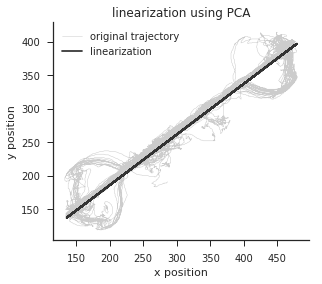

In [22]:
Xlinear_ = pca.inverse_transform(Xlinear)
ax = npl.plot2d(pos, lw=0.5, color='0.8', label='original trajectory')
plt.plot(Xlinear_[:,0], Xlinear_[:,1], color='0.2', label='linearization')
plt.legend()
ax.set_aspect('equal')  
ax.set_xlabel('x position')
ax.set_ylabel('y position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('linearization using PCA')

We also re-scale our data to range from 0 to 100 (so that we can express movement along the track as a percentage). Typically we would actually scale our data to some physical dimension or unit, such as cm, and not pixels as we have it above, or percentage, as we're transforming it into here.

In [23]:
Xlinear = Xlinear - np.min(Xlinear)
Xlinear = (Xlinear / np.max(Xlinear))*100

We now have `Xlinear` as a scaled (0 to 100) position variable, as a numpy array. We want to put it back into a `nelpy` `AnalogSignalArray` container, so that we can slice and interogate it as before:

In [24]:
pos1d = nel.AnalogSignalArray(Xlinear, timestamps=pos.time, support=pos.support, fs=60)
print('pos:  ', pos)
print('pos1d:', pos1d)

pos:   <AnalogSignalArray at 0x1bb229d81d0: 2 signals> for a total of 15:19:115 minutes
pos1d: <AnalogSignalArray at 0x1bb242d5a20: 1 signals> for a total of 15:19:115 minutes


We see that `pos1d` now only has 1 signal, as expected, and if we plot it, we can confirm that it ranges between 0 and 100:

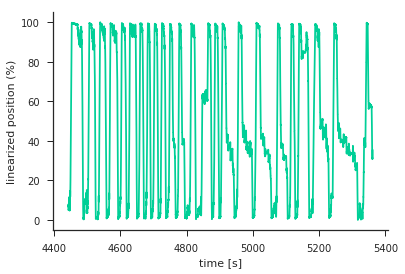

In [25]:
ax = npl.plot(pos1d)
ax.set_xlabel('time [s]')
ax.set_ylabel('linearized position (%)')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)

## 4. Extract spike times

We recorded extracellular activity in region CA1 of the hippocampus from a male Long-Evans rat, and we already performed spike detection and sorting (clusterting) in a separate program named MatClust (https://bitbucket.org/mkarlsso/matclust). MatClust is Matlab-based, and it gives us a .mat file with containing our sorted units and their associated spike times.

Luckily, we can read .mat files directly into Python, but the file format is still a little clunky, and so we need to parse it into a more intuitive format fisrt. For more information on the format of the .mat file, you can refer to https://github.com/nelpy/example-data/tree/master/linear-track.

At any rate, we extract spike times below, so that we end up with a list of lists, where the ith list is a list of the spike times associated with the ith unit. For example,

```
spikes = [[1, 2, 5, 10], [3, 5], [2, 9, 20]]
```
contains three units (three inner lists), with the spike times for the 1st unit being `[1, 2, 5, 10]` and those for the last unit being `[2, 9, 20]`. Spike times are given in seconds, so floating point numbers are used.

In [26]:
# load matlab file contining sorted spikes
mat = nel.io.matlab.load(filename_spikes)

# parse mat file contents into list of lists as described above
spikes = []
ct = 0
num_array = 0
for ii, array in enumerate(mat['spikes']):
    # If empty array, that particular tetrode was not sorted
    if (array.size > 1):
        for jj, subarray in enumerate(array):
            if (subarray.size != 0):
                # Exclude tetrodes with no spikes
                if (len(subarray['time'].ravel()[0]) != 0):
                    spikes.append(subarray['time'].ravel()[0])
                    ct +=1
    elif (array.size == 1):
        if (len(array['time'].ravel()[0]) != 0):
            spikes.append(array['time'].ravel()[0])
            ct +=1
print("Found {} non-empty units total".format(ct))

Found 31 non-empty units total


As before, we now put the list of spike times into a `nelpy` container object to make it easier to interact with the data. In particular, we put the spikes into a `SpikeTrainArray`. But first, let's also get out the time boundaries for which the spikes were recorded. We can approximate these boundaries by looking for the first and last recorded spikes, but the .mat file actually contains this information explicitly, so we'll get it directly from there:

In [27]:
start, stop = mat['spikes'][0][0]['timerange'].ravel()[0]

# Epoch for which spikes were recorded
session_bounds = nel.EpochArray([start, stop])

Now we're ready to build our `SpikeTrainArray`. We simply pass in the list of spike times, the epoch during which spikes were recorded, and the sampling rate (recall that we previously specified the sampling rate, FS=30000 Hz).

In [28]:
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=FS)
print(st)

<SpikeTrainArray at 0x1bb243de0f0: 31 units> at 30000 Hz


Printing out our `SpikeTrainArray` (`st`) tells us that we have 31 units, sampled at 30,000 Hz. 

We can ask several things from this `SpikeTrainArray` object, such as the number of spikes for each unit. To do that, we simply access the `.n_spikes` property, which returns the number of spikes associated with each unit as an array:

In [29]:
st.n_spikes

array([1748,  106,  352,   88,  875,  305,  145,  113,  408,  557, 1613,
        491,  270,  984, 1381, 7959,  931,   71,  477, 1183,  487,  816,
        479,   44, 1065,   92,   41, 2127,  901, 1179, 1541])

Of course, we can also compute these things manually. Let's take a step back, and compute the average firing rate for each unit, using not the `nelpy` `SpikeTrainArray`, but the original list of lists:

In [30]:
avg_firing_rates = []
st_duration = stop - start
for unit in spikes:
    n_spikes = len(unit)
    avg_firing_rate = n_spikes / st_duration
    avg_firing_rates.append(avg_firing_rate)
    
print(avg_firing_rates)

[0.88808809671340361, 0.053854312500927218, 0.17883696226723, 0.044709240566807501, 0.44455210790859734, 0.15495816332813964, 0.073668635024853268, 0.057410729364196, 0.20728829717338024, 0.28298917040581567, 0.81950005720750574, 0.24945723998071004, 0.13717607901179574, 0.49993059906521115, 0.70163024116774042, 4.0436459735366013, 0.47300344281474754, 0.036072228184583326, 0.24234440625417247, 0.60103444989242361, 0.24742500177312787, 0.41457659434676047, 0.24336052535796357, 0.022354620283403751, 0.54108342276874988, 0.04674147877438966, 0.020830441627717133, 1.0806426668818132, 0.45776165625788134, 0.59900221168484147, 0.78291976947102682]


This wasn't too difficult, but `nelpy` can make this a little easier.

Like all other core `nelpy` objects, a `SpikeTrainArray` has a _support_ on which it is defined, and so we can always get timing information by accessing the underlying support object (instead of using `start` and `stop` explicitly, as we did above).

Let's calculate the average firing rates using `nelpy` now:

In [31]:
avg_firing_rates = st.n_spikes / st.support.duration

print(avg_firing_rates)

[ 0.8880881   0.05385431  0.17883696  0.04470924  0.44455211  0.15495816
  0.07366864  0.05741073  0.2072883   0.28298917  0.81950006  0.24945724
  0.13717608  0.4999306   0.70163024  4.04364597  0.47300344  0.03607223
  0.24234441  0.60103445  0.247425    0.41457659  0.24336053  0.02235462
  0.54108342  0.04674148  0.02083044  1.08064267  0.45776166  0.59900221
  0.78291977]


Now wasn't that a little simpler? But the real beauty comes in when the `SpikeTrainArray` is not simply defined on one continuous epoch, but on many smaller epochs. For example, we might be interested in asking _"what is the average firing rate for each unit, during periods when the animal was running?"_---in that case, the firing rate calculation using the list of lists approach would become exceedingly painful, but we would be able to simply write
```
avg_firing_rates_during_run = st[run_epochs].n_spikes / st[run_epochs].support.duration 
```
which will work just the same, even though `st[run].support` now consists of many discontiguous epochs.

### Visualize spikes with raster plots

Nelpy has several built-in plot types (we have already seen `npl.plot2d()` before), and one that is frequently useful is the `rasterplot()`.

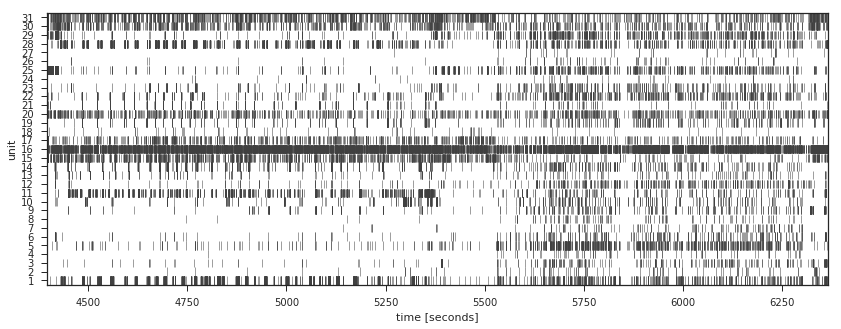

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(14,5))

# use nelpy to plot the spike raster
npl.rasterplot(st, lw=0.5, ax=ax)
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(*session_bounds.time);

We notice that there is a clear difference in overall activity between the run session (4400--5400 seconds) and when the animal was in its sleep box (5550--). For example, units 4, 7, 8, 26, 27, and 29 seem to be largely inactive during run, but active during the sleep box. Let's use the `rasterplot()` to highlight those units:

c:\etienne\dropbox\code\nelpy\nelpy\plotting\core.py:696: UserWarning: Spike trains may be plotted in the same vertical position as another unit
C:\Users\Etienne\Anaconda3\lib\site-packages\matplotlib\patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


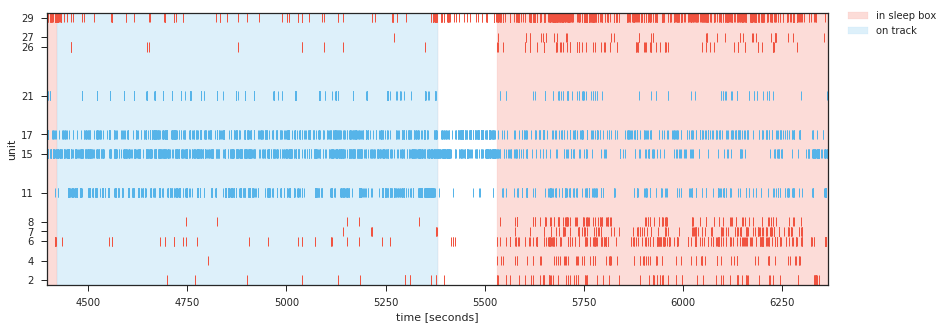

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(14,5))

units_in_sleepbox = [2, 4, 6, 7, 8, 26, 27, 29]
units_in_run = [11, 15, 17, 21]

transition_epoch = nel.EpochArray([5382, 5530])

# use nelpy to plot the spike rasters
npl.rasterplot(st[:,units_in_sleepbox], lw=1, ax=ax, color=npl.colors.sweet.red)
npl.rasterplot(st[:,units_in_run], lw=1, ax=ax, color=npl.colors.sweet.blue)

npl.epochplot(sleep_box-transition_epoch, alpha=0.2, hatch='', color=npl.colors.sweet.red, label='in sleep box')
npl.epochplot(~sleep_box, alpha=0.2, hatch='', color=npl.colors.sweet.blue, label='on track')
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(*session_bounds.time);

plt.legend(loc=(1.02,0.9))

The `rasterplot()` function has quite a bit of flexibility. As another example, let's plot the same as above, but let's collapse (stack) all the units onto each other:

C:\Users\Etienne\Anaconda3\lib\site-packages\matplotlib\patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


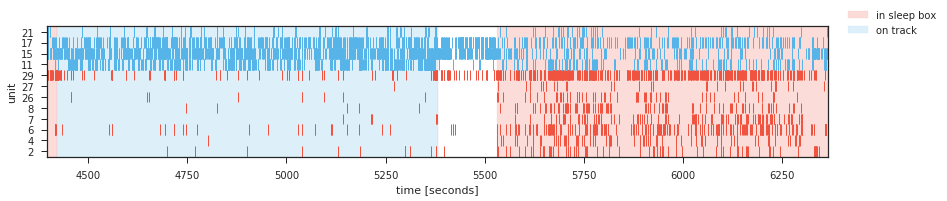

In [34]:
fig, ax = plt.subplots(ncols=1, figsize=(14,2.4))

units_in_sleepbox = [2, 4, 6, 7, 8, 26, 27, 29]
units_in_run = [11, 15, 17, 21]

transition_epoch = nel.EpochArray([5382, 5530])

# use nelpy to plot the spike rasters
npl.rasterplot(st[:,units_in_sleepbox], lw=1, ax=ax, color=npl.colors.sweet.red, vertstack=True)
npl.rasterplot(st[:,units_in_run], lw=1, ax=ax, color=npl.colors.sweet.blue, vertstack=True)

npl.epochplot(sleep_box-transition_epoch, alpha=0.2, hatch='', color=npl.colors.sweet.red, label='in sleep box')
npl.epochplot(~sleep_box, alpha=0.2, hatch='', color=npl.colors.sweet.blue, label='on track')
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(*session_bounds.time);

plt.legend(loc=(1.02,0.9))

We can even get a histogram with the number of spikes across all units by using the `npl.rastercountplot()` function. Note that this function is not yet fully developed, and still needs to be modified to increase flexibility.

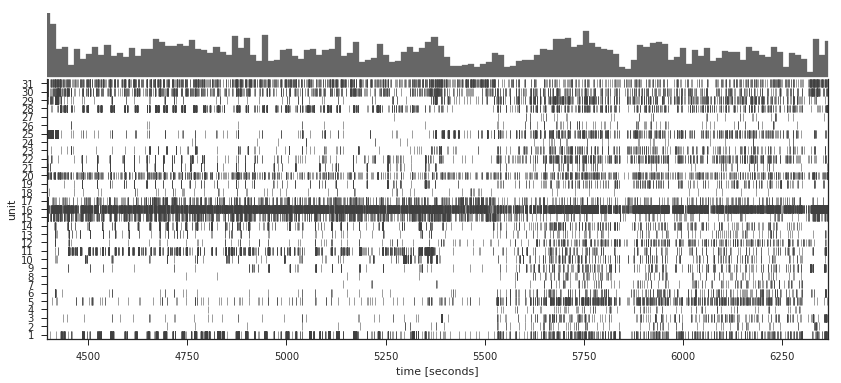

In [35]:
axc, axr = npl.rastercountplot(st, lw=0.5, nbins=130)
axes = (axr, axc)
axr.set_xlabel('time [seconds]')
axr.set_ylabel('unit')
for ax in axes:
    ax.set_xlim(*session_bounds.time);

One final raster example, where we call `rastercountplot()` on the list of units that seem to be more active in the sleep box than on the track:

C:\Users\Etienne\Anaconda3\lib\site-packages\matplotlib\patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


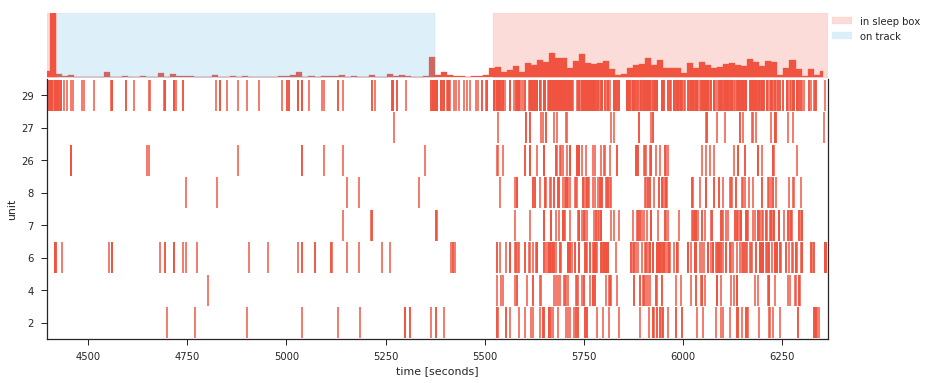

In [36]:
axc, axr = npl.rastercountplot(st[:,units_in_sleepbox], nbins=130, color=npl.colors.sweet.red, vertstack=True)
axes = (axr, axc)
axr.set_xlabel('time [seconds]')
axr.set_ylabel('unit')
for ax in axes:
    ax.set_xlim(*session_bounds.time);
    
npl.epochplot(sleep_box-transition_epoch, ax=axc, alpha=0.2, hatch='', color=npl.colors.sweet.red, label='in sleep box')
npl.epochplot(~sleep_box, ax=axc, alpha=0.2, hatch='', color=npl.colors.sweet.blue, label='on track')
axc.legend(loc=(1.0,0.5))

## 5. Estimate tuning curves

Next, we will use the position and spikes to estimate the spatial tuning curves of our 31 units.

Place fields are usually estimated using only those epochs when the animal is running faster than some speed threshold, so we find these epochs first. We smooth our speed estimates with a Guassian kernel with sigma = 100 ms, and then we return those epochs where the animal was running at least 8 percent per second.

**Note**: Usually we would measure the speed in cm/s or similar, but recall that our position has been scaled to be a percentage; the track was about 117 cm long, so that percent/s is not too different from cm/s.

In [37]:
sigma_100ms = 0.1

# compute and smooth speed of linearized position
speed1 = nel.utils.dxdt_AnalogSignalArray(pos1d, smooth=True, sigma=sigma_100ms)

# find epochs where the animal ran at least as fast as v1=8 percent per second
run_epochs = nel.utils.get_run_epochs(speed1, v1=8, v2=8)

The `get_run_epochs()` function has two thresholds (both set to 8 above). More specifically, the first threshold (`v1`) is referred to as the primary threshold, and this must be reached or exceeded for an epoch to be considered a candidate. But then the secondary threshold (`v2`) is used to determine the epoch boundaries.

For example, if we had used `v1=8, v2=5` then only epochs during which the animal reached a speed of at least 8 u/s would be considered, and the epoch boundaries would be when the animal ran ran at or slower than 5 u/s, starting at the peak speed of >8 u/s.

There are other possible arguments, too, so that we can e.g. ask that the animal must run at least 8 u/s for some minimum period of time, and so on.

Let's see for how much time the animal actually ran faster than 8 percent per second:

In [38]:
print(run_epochs)

<EpochArray at 0x1bb25a08c88: 221 epochs> of duration 4:18:131 minutes


We see that there are 221! short epochs during the animal ran sufficiently fast, and that the total amount of time spent running at this speed or faster, is about 4 minutes and 18 seconds (out of approximately 16 minutes spent on the track).

As promised before, we can now easily (trivially) calculate the firing rates of all the units, only during times when the animal was running:

In [39]:
avg_firing_rates_during_run = st[run_epochs].n_spikes / st[run_epochs].support.duration 

for unit, (run_rate, avg_rate) in enumerate(zip(avg_firing_rates_during_run, avg_firing_rates)):
    print('unit {}: {:2.3f} Hz (run and rest: {:2.3f} Hz)'.format(unit+1, run_rate, avg_rate))

unit 1: 1.058 Hz (run and rest: 0.888 Hz)
unit 2: 0.004 Hz (run and rest: 0.054 Hz)
unit 3: 0.023 Hz (run and rest: 0.179 Hz)
unit 4: 0.000 Hz (run and rest: 0.045 Hz)
unit 5: 0.112 Hz (run and rest: 0.445 Hz)
unit 6: 0.046 Hz (run and rest: 0.155 Hz)
unit 7: 0.000 Hz (run and rest: 0.074 Hz)
unit 8: 0.015 Hz (run and rest: 0.057 Hz)
unit 9: 0.360 Hz (run and rest: 0.207 Hz)
unit 10: 0.019 Hz (run and rest: 0.283 Hz)
unit 11: 3.281 Hz (run and rest: 0.820 Hz)
unit 12: 0.132 Hz (run and rest: 0.249 Hz)
unit 13: 0.418 Hz (run and rest: 0.137 Hz)
unit 14: 2.243 Hz (run and rest: 0.500 Hz)
unit 15: 1.786 Hz (run and rest: 0.702 Hz)
unit 16: 6.318 Hz (run and rest: 4.044 Hz)
unit 17: 0.856 Hz (run and rest: 0.473 Hz)
unit 18: 0.077 Hz (run and rest: 0.036 Hz)
unit 19: 0.666 Hz (run and rest: 0.242 Hz)
unit 20: 1.251 Hz (run and rest: 0.601 Hz)
unit 21: 1.449 Hz (run and rest: 0.247 Hz)
unit 22: 0.701 Hz (run and rest: 0.415 Hz)
unit 23: 0.209 Hz (run and rest: 0.243 Hz)
unit 24: 0.000 Hz (r

We can also plot the linearized trajectory only during those run epochs. Each new color indicates that it is a new epoch. The black on the bottom figure corresponds to epochs when the animal did not meet the 8 percent per second requirement, and so those are when the animal is considered to be at rest.

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


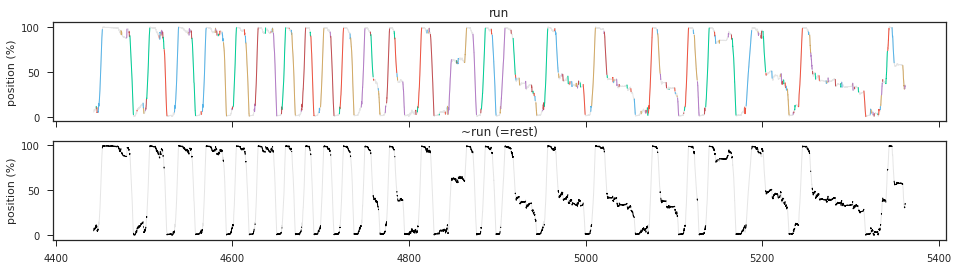

In [40]:
with npl.FigureManager(show=True, nrows=2, figsize=(16,4)) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    for ax in axes:
        ax.plot(pos1d.time, pos1d.asarray().yvals, lw=1, alpha=0.2, color='gray')
        ax.set_ylabel('position (%)')
    
    npl.plot(pos1d[run_epochs], ax=ax0, lw=1, label='run')
    npl.plot(pos1d[~run_epochs], ax=ax1, lw=1, label='run', color='k')
    
    npl.utils.no_xticklabels(ax0)
    
    ax0.set_title('run')
    ax1.set_title('~run (=rest)')

Now that we have the epochs during which the animal was running, we can use it to restrict our `SpikeTrainArray` to those epochs. Then we will use these spikes, along with the position data, to estimate the spatial tuning curves.

In [41]:
st_run = st[run_epochs] # restrict spike trains to those epochs during which the animal was running

We bin our spikes into 50 ms bins, so that we can count the number of spikes in a small window of time, which we will then later associate with the particular position bin that the animal was at when those spikes occured.

We also apply a little bit of spike time smoothing.

In [42]:
ds_run = 0.5 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...


We now estimate the tuning curves using the binned spikes during run (`bst_run`), and we partition our linear track into `n_extern=50` equal-sized spatial bins, and we specify that the linearized position ranges from `extmin=0` to `extmax=100`. We also smooth the estimated tuning curves with a 0.2 cm smoothing kernel (this should be imperceptable, and a larger value for sigma should really be used, but we can always apply the smoothing later, so it's not a real problem).

In [43]:
sigma = 0.2 # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_run, extern=pos1d, n_extern=50, extmin=0, extmax=100, sigma=sigma, min_duration=1)

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified


Finally, we reorder the units by their peak firing positions on the track, simply to make visualization a little nicer:

In [44]:
tc = tc.reorder_units()

That's it! Let's see what we've got:

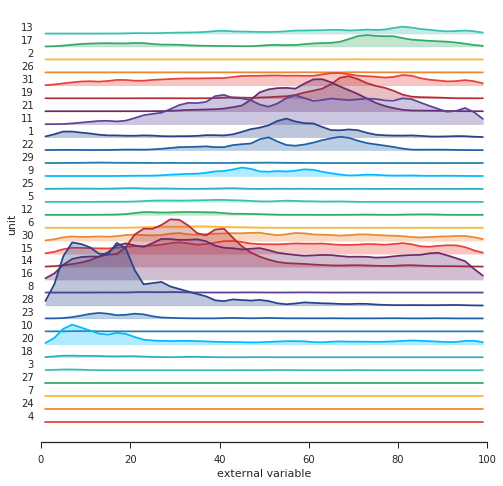

In [45]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=False, pad=3)

We see that some units have spatially localized tuning curves, and some don't. Also, some units have large firing rates, and some don't. To see the shape of all the tuning curves better, we can normalize the peak firing rates like so:

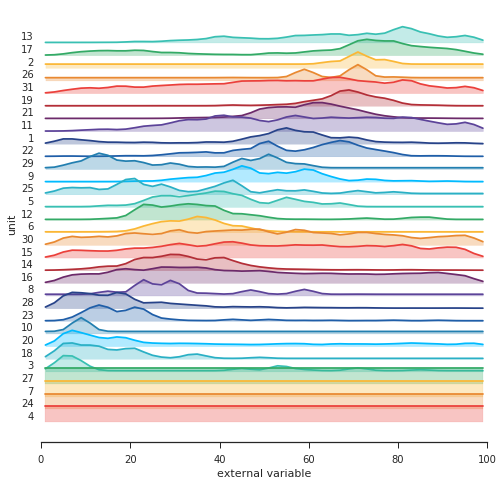

In [46]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=True, pad=0.8)

This normalized view allows us to see the shapes of the tuning curves more clearly, and we can see that units 4, 24, and 7 are essentially flat, meaning they have NO spatial localization for their firing rates. This is partly due to there just being almost no spikes during run for those units though.

At any rate, let's filter out the units a little further, to try and figure out which ones might actually be place cells.

### Restrict subset of cells (units) to use for subsequent decoding and/or analysis

Here we may request to use
1. unimodal cells only,
1. pyramidal cells only,
1. active cells only,
1. any combination of the above, and other criteria

Here we only impose a minimum peak firing rate of 1.5 Hz, and we reject putative interneurons by imposing a maximum average firing rate of 5 Hz averaged over the entire track.

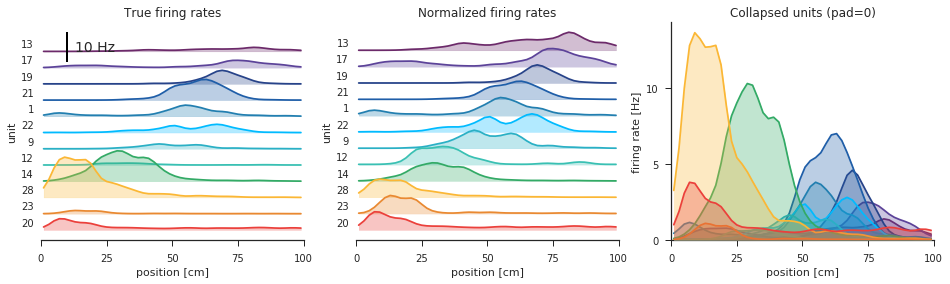

In [47]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 3.5 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))


# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = st._unit_subset(unit_ids_to_keep)

tc = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc.reorder_units(inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,4)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 57), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)

## 6. Evaluate decoding performance

Next, having defined a subset of 12 place cells, we may reasonably want to ask how well these cells can represent the animal's location? We can evaluate the expected decoding performance by using a Bayesian decoder, and by evaluating the decoding accuracy on a test set.

Here, we use 5-fold cross-validation and the tuning curves of our 12 place cells to evaluate the performance, and the results are summarized in the figure below: 

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been sp

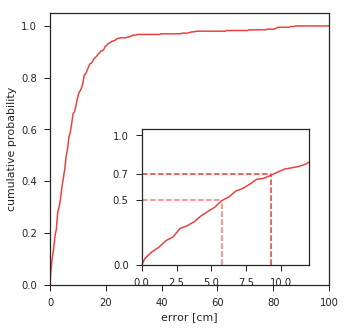

In [48]:
with npl.FigureManager(show=True, figsize=(5,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    ds_run = 0.5 # 100 ms
    ds_1ms = 0.01
#     st_run = st[run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds_1ms).smooth(sigma=0.5, inplace=True).rebin(w=ds_run/ds_1ms)
    
    bst = bst_run

    cumhist, bincenters = nel.decoding.cumulative_dist_decoding_error_using_xval(bst, extern=pos1d, extmax=100)
    npl.plot_cum_error_dist(bst=bst, extern=pos1d, extmin=0, extmax=100);


This tells us that, with probability 0.9, we can decode the animal's position to within 20 percent of the true position. Recall that in our particular example, percent and cm are almost the same. The inset shows a zoomed-in view, from where we can see that with probability 0.7, we have an error of less than 10 percent.

It's not the best decoding accuracy imaginable, but overall, not bad!

## Some additional views

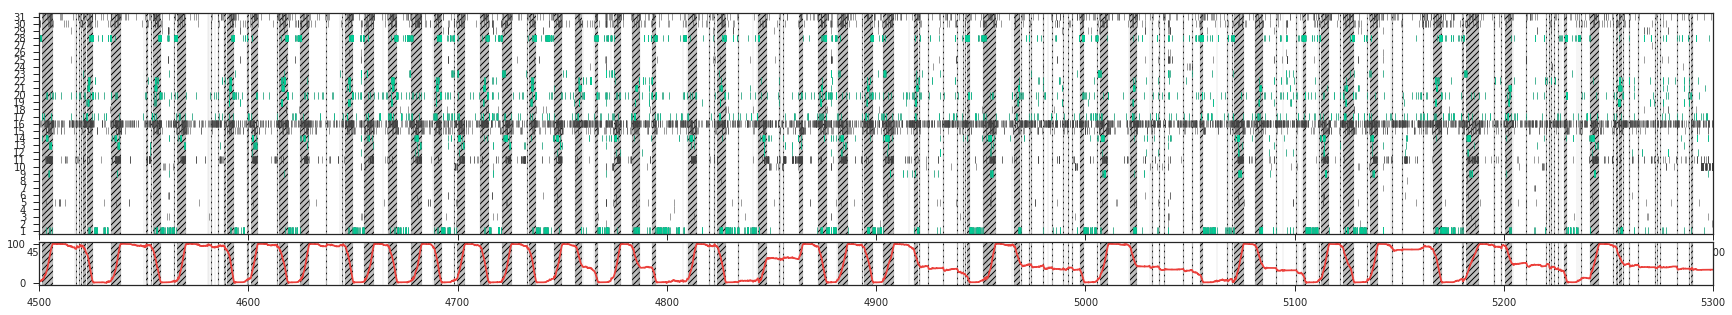

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with npl.FigureManager(show=True, figsize=(30,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.rasterplot(sta_placecells, lw=0.5, color=npl.colors.sweet.green)
    npl.epochplot(run_epochs)

    divider = make_axes_locatable(ax)

    axSpeed1d = divider.append_axes("bottom", size=0.6, pad=0.1)
    npl.plot(pos1d, ax=axSpeed1d)
    npl.epochplot(run_epochs, ax=axSpeed1d)

    xlims = (4500, 5300)

    ax.set_xlim(xlims)
    axSpeed1d.set_xlim(xlims)



Next, we take a look at where on the track spikes from a particular unit occurred:

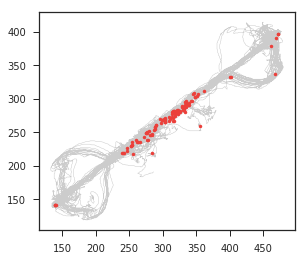

In [50]:
ax = npl.plot2d(pos, lw=0.5, c='0.8')
unit_id = 9
_, pos_at_spikes = pos.asarray(at=st[:,unit_id].time)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')

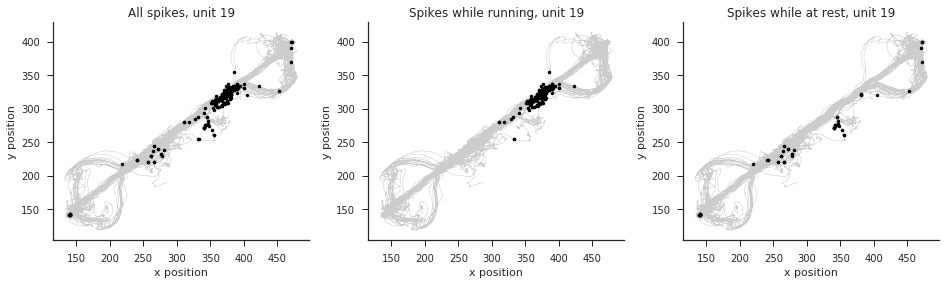

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

ax0, ax1, ax2 = axes

# plot trajectory in gray
for ax in axes:
    npl.plot2d(pos, lw=0.5, c='0.8', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)

unit_id = 19

# all spikes
at = st.loc[:,unit_id][pos.support].time
_, pos_at_spikes = pos.asarray(at=at)
ax0.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax0.set_aspect('equal')
ax0.set_title('All spikes, unit {}'.format(unit_id))

# spikes during RUN
at = st.loc[:,unit_id][run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax1.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax1.set_aspect('equal')
ax1.set_title('Spikes while running, unit {}'.format(unit_id))

# spikes during REST
at = st.loc[:,unit_id][~run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax2.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax2.set_aspect('equal')
ax2.set_title('Spikes while at rest, unit {}'.format(unit_id))

## Conclusion


This demo is still a work in progress, but hopefully it highlights a few ways in which using `nelpy` might make it easier to combine and analyze ephys data with different sampling rates, and different epochs where they are defined. There's a lot more that we can do with `nelpy`, so feel free to dig a little deeper to explore!

Feedback about this notebook would be appreciated, and can be sent to era3@rice.edu.